# Requesting Weather Data

In [ ]:
import datetime
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

import matplotlib.pyplot as plt

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2024-03-14",
	"end_date": "2024-03-28",
	"hourly": ["rain", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high"],
	"daily": "sunshine_duration",
	"timezone": "America/Chicago"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]

# FILEPATH: /home/hasi/Documents/weather.ipynb
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
start_date = datetime.datetime(2000, 4, 9)
end_date = datetime.datetime(2023, 4, 10)

dates = pd.date_range(start=start_date, end=end_date, freq='D')

dates = dates[dates.month == 4]
dates = dates[dates.day == 9]

lat, long = 38.1155, -88.4809 
data = []

for date in dates:

	params = {
		"latitude": lat,
		"longitude": long,
		"start_date": date.strftime("%Y-%m-%d"),
		"end_date": date.strftime("%Y-%m-%d"),
		"hourly": ["rain", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high"],
		"daily": "sunshine_duration",
		"timezone": "America/Chicago"
	}
	responses = openmeteo.weather_api(url, params=params)

	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]

	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_rain = hourly.Variables(0).ValuesAsNumpy()
	hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
	hourly_cloud_cover_low = hourly.Variables(2).ValuesAsNumpy()
	hourly_cloud_cover_mid = hourly.Variables(3).ValuesAsNumpy()
	hourly_cloud_cover_high = hourly.Variables(4).ValuesAsNumpy()

	hourly_data = {
		"date": pd.date_range(
			start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
			end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
			freq=pd.Timedelta(seconds=hourly.Interval()),
			inclusive="left"
		)
	}
	hourly_data["rain"] = hourly_rain
	hourly_data["cloud_cover"] = hourly_cloud_cover
	hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
	hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
	hourly_data["cloud_cover_high"] = hourly_cloud_cover_high

	hourly_dataframe = pd.DataFrame(data=hourly_data)
	data.append(hourly_dataframe)

# Concatenate all dataframes into a single dataframe
all_data = pd.concat(data)

#print(all_data)


# Finding the nearest town

In [2]:
import reverse_geocode

def closest_town(lati, longi):
    location = (lati, longi),
    return reverse_geocode.search(location)


town = closest_town(lat, long)

# Nearest Airports

In [19]:
import pandas as pd

data_path = '/home/hasi/Documents/data science/projects/weather_history/airports.csv'
df = pd.read_csv(data_path)

# Print the DataFrame
df.head()


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,K00A,NaN,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,00AN,NaN,00AN,NaN,NaN,NaN


In [20]:
distinct_types = df['type'].unique()
print(distinct_types)


['heliport' 'small_airport' 'closed' 'seaplane_base' 'balloonport'
 'medium_airport' 'large_airport']


In [52]:
from geopy.distance import geodesic
import csv

data_path = '/home/hasi/Documents/data science/projects/weather_history/airports.csv'
# Load airport data (assuming a CSV file with 'name', 'latitude', and 'longitude' columns)
def load_airports(file_path):
    airports = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            airports.append({
                'name': row['name'],
                'type': row['type'],
                'coordinates': (float(row["latitude_deg"]), float(row['longitude_deg']))
            })
    airports = [airport for airport in airports if 'large_airport' in airport['type'] or 'medium_airport' in airport['type']]
    return airports

# Find airports within a specified radius (in kilometers) from a given point
def find_airports_within_radius(airports, latitude, longitude, radius_miles):
    origin = (latitude, longitude)
    nearby_airports = []
    for airport in airports:
        distance_miles  = geodesic(origin, airport['coordinates']).miles
       
        
        if distance_miles <= radius_miles:
            nearby_airports.append((airport['name'], distance_miles, airport['type']))
    return nearby_airports

# Example usage
airports = load_airports(data_path)  # Update this path to your CSV file
r_min = 130  # distance in miles

nearby_airports = find_airports_within_radius(airports, lat, long, r_min)  # Searching within 50km radius of the example coordinates
nearby_airports = sorted(nearby_airports, key=lambda x: (x[2], x[1])) # Sort by airport type and then by distance

# Create a DataFrame from the nearby_airports list
df = pd.DataFrame(nearby_airports, columns=['name', 'distance', 'type'])

if not nearby_airports:
    print("No airports found within the specified radius")
else:
    print(df)


                                          name    distance            type
0       St Louis Lambert International Airport  111.407362   large_airport
1                    Southern Illinois Airport   48.115483  medium_airport
2                  Evansville Regional Airport   51.994546  medium_airport
3                     Barkley Regional Airport   74.492573  medium_airport
4             Owensboro Daviess County Airport   76.314475  medium_airport
5                 Scott AFB/Midamerica Airport   79.323855  medium_airport
6              Cape Girardeau Regional Airport   85.666792  medium_airport
7                    St Louis Regional Airport  100.259293  medium_airport
8   Terre Haute Regional Airport, Hulman Field  111.826087  medium_airport
9       Campbell Army Airfield (Fort Campbell)  113.375132  medium_airport
10                             Decatur Airport  120.382198  medium_airport
11                       Monroe County Airport  123.389451  medium_airport
12                  Spiri

In [32]:
df[df['name'] == 'St Louis Regional Airport']


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
36079,3374,KALN,medium_airport,St Louis Regional Airport,38.890301,-90.045998,544.0,NaN,US,US-IL,Alton/St Louis,no,KALN,ALN,ALN,NaN,https://en.wikipedia.org/wiki/St._Louis_Region...,Civic Memorial Airport


/tmp/ipykernel_62327/2493156067.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cloud_coverage_data = cloud_coverage_data.append(selected_data[['date', 'cloud_cover']].rename(columns={'date': 'Hour', 'cloud_cover': 'Cloud Cover'}))
/tmp/ipykernel_62327/2493156067.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cloud_coverage_data = cloud_coverage_data.append(selected_data[['date', 'cloud_cover']].rename(columns={'date': 'Hour', 'cloud_cover': 'Cloud Cover'}))
/tmp/ipykernel_62327/2493156067.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cloud_coverage_data = cloud_coverage_data.append(selected_data[['date', 'cloud_cover']].rename(columns={'date': 'Hour', 'cloud_cover': 'Cloud Cover'}))
/tmp/ipykernel_62327/2

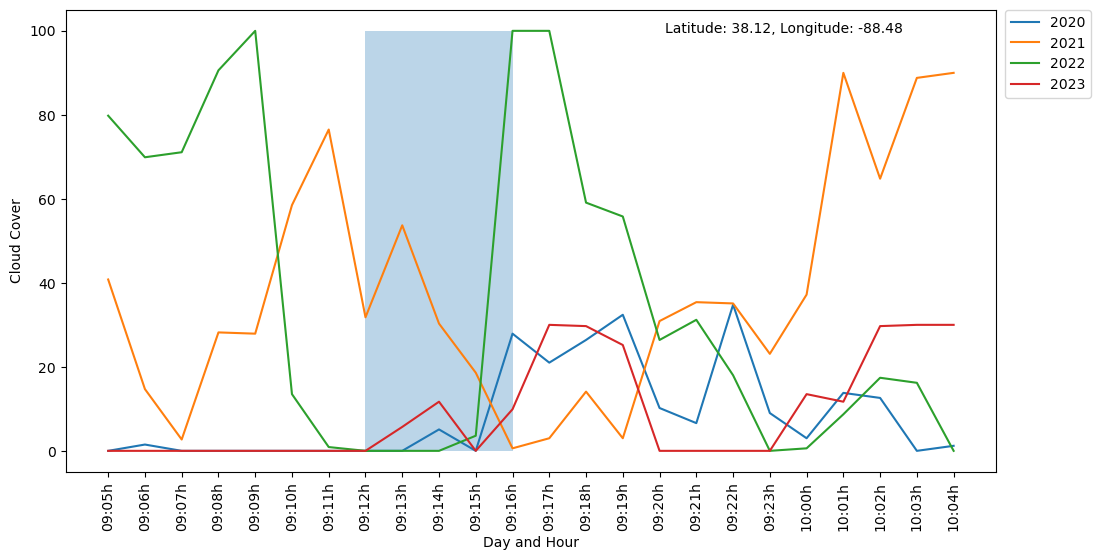

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a specific date
import matplotlib.pyplot as plt

# Choose specific years and days
selected_years = np.arange(2020, 2024)
selected_days = [9, 10]

# Create an empty DataFrame to store the cloud coverage data
cloud_coverage_data = pd.DataFrame(columns=['Year', 'Day', 'Hour', 'Cloud Cover'])

# Iterate over the selected years and days
for year in selected_years:
    for day in selected_days:
        # Filter the data for the selected year and day
        selected_data = all_data[((all_data['date'].dt.year == year) & (all_data['date'].dt.day == day))]
        
        # Append the cloud coverage data to the DataFrame
        cloud_coverage_data = cloud_coverage_data.append(selected_data[['date', 'cloud_cover']].rename(columns={'date': 'Hour', 'cloud_cover': 'Cloud Cover'}))
        
# Reset the index of the DataFrame
cloud_coverage_data.reset_index(drop=True, inplace=True)

# Print the cloud coverage data
#print(cloud_coverage_data)

# Filter the data for the selected date
#selected_data = all_data[((all_data['date'].dt.year == selected_year)& (all_data['date'].dt.day == selected_day))]
#selected_data = selected_data.sort_values(by=selected_data['date'].dt.hour.values)

# Group the data by year
grouped_data = cloud_coverage_data.groupby(cloud_coverage_data['Hour'].dt.year)

fig = plt.figure(figsize=(12, 6))

for year, group in grouped_data:
    x = group['Hour'].dt.strftime('%d:%Hh')  # Format the x-axis as day:hour
    plt.plot(x, group['Cloud Cover'], label=str(year))

plt.xlabel('Day and Hour')
plt.ylabel('Cloud Cover')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Get the x values for the shaded area
x_values = grouped_data.get_group(2022)['Hour'].dt.strftime('%d:%Hh')

# Set the start and end indices for the shaded area
start_index = x_values.tolist().index('09:12h')
end_index = x_values.tolist().index('09:16h')

# Shade the area between the start and end indices
plt.fill_between(x_values[start_index:end_index+1], 0, 100, alpha=0.3)

# Add latitude and longitude to the plot
plt.text(0.9, 0.95, f'Latitude: {lat:.2f}, Longitude: {long:.2f}', transform=plt.gca().transAxes, ha='right')
plt.text(0.9, 0.95, f'Latitude: {lat:.2f}, Longitude: {long:.2f}', transform=plt.gca().transAxes, ha='right')

# Draw a rectangle around the latitude and longitude
#rect = plt.Rectangle((0.98, 0.009), 0., 0.03, fill=False, edgecolor='red', linewidth=2)
#plt.Rectangle
#plt.gca().add_patch(rect)
fig.savefig('/home/hasi/Documents/data science/projects/' + 'weather_history/cloud-cover.png',
           dpi=600,format='png',bbox_inches='tight')
plt.show()



# Modeling the Path of Totality

In [77]:
import numpy as np

# Data points
g0 = [28.8669, -100.5548]
g1 = [32.5251, -96.4035]
g2 = [40.3839, -84.3683]
g3 = [41.2172, -82.6484]
g4 = [46.0759, -68.8376]
g5 = [32.3553, -96.6073]

# Latitude values
latitudes = [g0[0], g1[0], g2[0], g3[0], g4[0]]

# Longitude values
longitudes = [g0[1], g1[1], g2[1], g3[1], g4[1]]

# Fit a polynomial curve
coefficients = np.polyfit(latitudes, longitudes, deg=2)

# Define the fitted curve as a function of latitude
def fitted_curve(latitude):
    return coefficients[0] * latitude**2 + coefficients[1] * latitude + coefficients[2]

# Test the fitted curve
latitude = lat
longitude = fitted_curve(latitude)
print(f"The longitude for latitude {latitude} is {longitude}")


The longitude for latitude 38.1155 is -88.83886535466299


In [78]:
latitude = 40.4018
longitude = fitted_curve(latitude)
print(f"The longitude for latitude {latitude} is {longitude}")

The longitude for latitude 40.4018 is -84.11839149521218


In [82]:
from geopy.distance import geodesic

# Define the coordinates of the two points
point1 = (40.4018, -84.11839149521218)  # For example, (40.748817, -73.985428) for the Empire State Building
point2 = (40.4018, -84.3263)  # For example, (51.5074, -0.1278) for London

# Calculate the distance
distance = geodesic(point1, point2).miles  # or .miles

print(f"The distance between the two points is {distance} miles.")

The distance between the two points is 10.966957355892891 miles.


In [ ]:
import geopy.distance
import numpy as np

def calculate_shortest_distance(fitted_curve, longitude, latitude):
    # Calculate the distance from the fitted curve to the given longitude and latitude
    distances = []
    for point in fitted_curve:
        point_longitude, point_latitude = point
        distance = geopy.distance.geodesic((latitude, longitude), (point_latitude, point_longitude)).miles
        distances.append(distance)
    
    # Find the shortest distance
    shortest_distance = np.min(distances)
    
    return shortest_distance



In [84]:
from geopy.distance import geodesic
import numpy as np

# Example function for the curve: latitude as a function of longitude
# This is just an example; replace it with your actual function


# Point from which we want to find the shortest distance to the curve
point = (40.4018, -84.11839149521218)   # (latitude, longitude)

# Generate sample points along the curve
latitudes = np.linspace(25, 50, 1000)  # Sample 1000 points between -180 and 180 degrees
longitudes = fitted_curve(latitudes)

# Calculate distances and find the minimum distance
min_distance = float('inf')
closest_point = None
for lon, lat in zip(longitudes, latitudes):
    curve_point = (lat, lon)
    distance = geodesic(point, curve_point).kilometers
    if distance < min_distance:
        min_distance = distance
        closest_point = curve_point

print(f"Shortest distance is {min_distance} kilometers to the point {closest_point}.")


Shortest distance is 2.5050079775591705 kilometers to the point (40.390390390390394, -84.1438454062265).
